# Amplitude of seasonal cycle (by season)

- use the mmm dataset 
- group the data by season
- take the amplitude of the seasoal cycle (Tmax-Tmin) for each grid point (for mmm)
- select out regions and take llm
- plot time series of seasonal cycle for each region 

In [1]:
import xarray as xr, matplotlib.pyplot as plt
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load
import climtas # needed to count event statistics with a specified duration
import seaborn as sns
import scipy.stats # to calculate correlation

In [2]:
# import custom functions
import sys 
sys.path.append('/home/563/kb6999/Functions') # use this if the function file is in a different directory to the notebook

import frequently_used_functions as func
import plotting_functions as fplot
import model_functions as funcM
import reanalysis_functions as funcR

## read in 20CR data

In [3]:
path = '/g/data/w48/kb6999/20CR_TMP_raw_data_for_plots/'

In [6]:
# mmm but not llm
mmm_raw_glob = xr.open_dataset(f'{path}mmm_raw_glob.nc')
mmm_raw_glob

<xarray.Dataset>
Dimensions:  (lat: 256, lon: 512, time: 1992)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2015-12-31
  * lon      (lon) float32 0.0 0.703 1.406 2.109 ... 357.1 357.8 358.5 359.2
  * lat      (lat) float32 89.46 88.77 88.07 87.37 ... -88.07 -88.77 -89.46
Data variables:
    tmp      (time, lat, lon) float32 ...

In [7]:
# group the raw data by season
mmm_seasonal_glob = func.seasonal_group(mmm_raw_glob)
mmm_seasonal_glob

<xarray.Dataset>
Dimensions:     (lat: 256, lon: 512, season: 4, seasonyear: 167)
Coordinates:
  * season      (season) object 'DJF' 'JJA' 'MAM' 'SON'
  * lon         (lon) float32 0.0 0.703 1.406 2.109 ... 357.1 357.8 358.5 359.2
  * lat         (lat) float32 89.46 88.77 88.07 87.37 ... -88.07 -88.77 -89.46
  * seasonyear  (seasonyear) int64 1850 1851 1852 1853 ... 2013 2014 2015 2016
Data variables:
    tmp         (seasonyear, season, lat, lon) float32 -0.3049 -0.3048 ... nan

In [8]:
season_amp = func.seasonal_amp(mmm_seasonal_glob).sel(seasonyear=slice('1850','2015'))

In [9]:
season_amp_Glob = season_amp.mean(dim=['lat','lon'])

In [10]:
# import landmask dataset 
landfrac_ds = xr.open_dataset('/g/data/w48/kb6999/20CR_data_netcdfs/land_20CR.nc')
landmask = landfrac_ds

In [11]:
# Select out SH and NH anomalies 
season_amp_SH = season_amp.sel(lat=slice(0,-90)) 
season_amp_NH = season_amp.sel(lat=slice(90,0)) 
# select out the Australian and E Australian anomalies 
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    season_amp_Aus = season_amp.sel(lat=slice(-10,-50), lon=slice(110,160)).where(landmask.LAND==1.0, drop=True)
    season_amp_EA = season_amp.sel(lat=slice(-10,-50), lon=slice(140,155)).where(landmask.LAND==1.0, drop=True)

In [12]:
# take the lat lon mean
season_amp_SH = season_amp_SH.mean(dim=['lat','lon'])
season_amp_NH = season_amp_NH.mean(dim=['lat','lon'])
season_amp_Aus = season_amp_Aus.mean(dim=['lat','lon'])
season_amp_EA = season_amp_EA.mean(dim=['lat','lon'])

In [13]:
season_amp_EA.seasonyear

<xarray.DataArray 'seasonyear' (seasonyear: 166)>
array([1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861,
       1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873,
       1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885,
       1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897,
       1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909,
       1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921,
       1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933,
       1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945,
       1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957,
       1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
       1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015])
Coordinates:
  * seasonyear  (seasonyear) int64 1850 1851 1852 1853 ... 2012 2013 2014 2015

## figures

In [14]:
# define degree sign
deg = u'\N{DEGREE SIGN}'

In [15]:
fplot = reload(fplot)

In [26]:
# define a function for subplots in the timeseries
def timeseries_graph(mmm_dataset, p10 = None, p90 = None, ax = None, **kwargs):
    """Create subplots of a time series, use shading to indicate 10th and 90th percentiles.  
    Add lines to show dates of five major eruptions between 1850-2014.  
    Return the axis.  
    
    Args:
        mmm_dataset (array): array of values (multi-model mean of climate variable) to be plotted in time series 
        p10 (array): array of values of 10th percentile
        p90 (array): array of values of 90th percentile
        ax (axis): axis
        **kwargs
    """
    import matplotlib.pyplot as plt, numpy as np
    
    # checking if an axis has been defined and if not creates one with function "get current axes"
    if ax is None:
        ax = plt.gca()
        
    # SUBPLOT
    # plot the percentiles (.data isn't necessary but maybe helps speed it up??)
    # (Note: be careful how you check p10 array, cos can't use 'p10 != None' for an array cos an array has multiple truth values
    # one way around this is to use 'type(p10) == type(None)')
    if p10 is not None: 
        ax.fill_between(p10.time.data, p10.data, p90.data, **kwargs)#, color='lightcoral')
    # plot the multi_model mean
    mmm_dataset.plot(color = 'crimson', ax=ax)#, **plt_kwargs)

    ax.grid(which='major', linestyle='-', linewidth='0.5', color='k') # customise major grid
    ax.minorticks_on() # need this line in order to get the minor grid lines 
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='k')
    
    # specify an array of eruption dates so I can mark the dates where erutpions occur on the plot
    e_dates = [np.array('1883', dtype='int64'),
               np.array('1902', dtype='int64'),
               np.array('1963', dtype='int64'),
               np.array('1982', dtype='int64'),
               np.array('1991', dtype='int64')] 
    
    # Plot a dashed line to show the eruption time for the 5 major eruptions
    for date in e_dates:
        if date in mmm_dataset.seasonyear.data:
            ax.axvline(x=date, color = 'k', linestyle = '--', alpha = 0.9, linewidth='1.5')
    
    #label axes
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    
    return ax

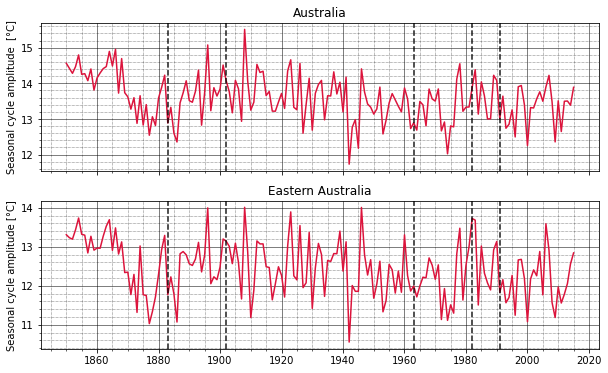

In [27]:
# Monthly temperature seasonal cycle amplitude stacked
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10,6)) # make a figure

with dask.diagnostics.ProgressBar():
    timeseries_graph(season_amp_Aus.tmp, ax = axes[0])
    timeseries_graph(season_amp_EA.tmp, ax = axes[1])

axes[0].set(ylabel= f'Seasonal cycle amplitude  [{deg}C]', title = 'Australia')
axes[1].set(ylabel= f'Seasonal cycle amplitude [{deg}C]', title = 'Eastern Australia')

# set xticks and labels
axes[1].set_xticks(np.arange(min(season_amp_Aus.seasonyear)+10, max(season_amp_Aus.seasonyear)+11, 20))

#fig.suptitle('Time series of temperature anomalies', size=16)

#fig.tight_layout() # makes titles overlap, but is meant to stops things from overlapping and makes the figure more compact

plt.savefig('R_timeseries_s_seasonal_amp_tmp_Aus_EA.png', dpi=300, bbox_inches='tight')

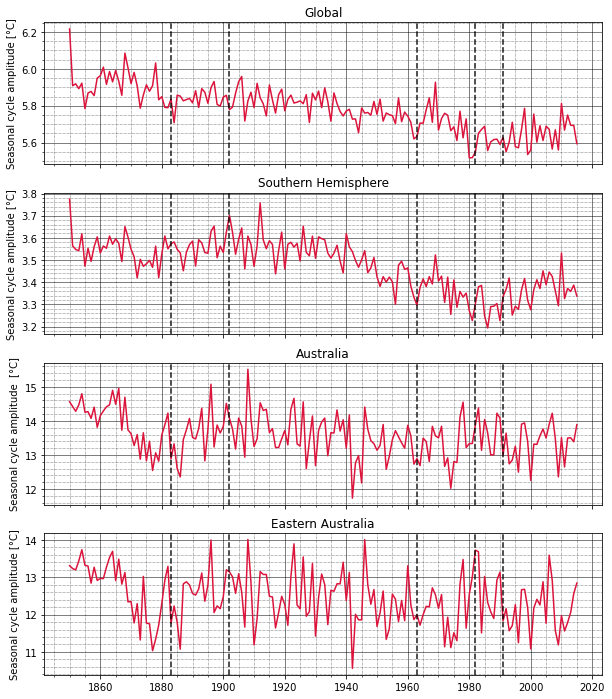

In [28]:
# Monthly temperature seasonal cycle amplitude stacked
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10,12)) # make a figure

with dask.diagnostics.ProgressBar():
    timeseries_graph(season_amp_Glob.tmp, ax = axes[0])
    timeseries_graph(season_amp_SH.tmp, ax = axes[1])
    timeseries_graph(season_amp_Aus.tmp, ax = axes[2])
    timeseries_graph(season_amp_EA.tmp, ax = axes[3])

axes[0].set(ylabel= f'Seasonal cycle amplitude [{deg}C]', title = 'Global') 
axes[1].set(ylabel= f'Seasonal cycle amplitude [{deg}C]', title = 'Southern Hemisphere')
axes[2].set(ylabel= f'Seasonal cycle amplitude  [{deg}C]', title = 'Australia')
axes[3].set(ylabel= f'Seasonal cycle amplitude [{deg}C]', title = 'Eastern Australia')

# set xticks and labels
axes[3].set_xticks(np.arange(min(season_amp_Glob.seasonyear)+10, max(season_amp_Glob.seasonyear)+11, 20))

#fig.suptitle('Time series of temperature anomalies', size=16)

#fig.tight_layout() # makes titles overlap, but is meant to stops things from overlapping and makes the figure more compact

plt.savefig('R_timeseries_s_seasonal_amp_tmp_stacked.png', dpi=300, bbox_inches='tight')